In [9]:
#Import Statements
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
from IPython.display import Image
import os
from os import path
import pandas as pd
from scipy.signal import find_peaks
import glob
import math
from IPython.display import clear_output
import time

## Lab 1: Pretty Picture

In [10]:
#Functions

def fits_data_to_3d_array(file_list): 
    '''
    Takes in a list of fits files and converts data into a 3d array
    Parameters:
        file_list (list): List containing paths of FITS files to convert.
    Returns:
        final_array: 3d array of data from each fits file.
    '''    
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Creates a median combine of a 3d array
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
 
def save_array_to_fits_file(array, new_file_name):
    '''
    Saves a 2d array of pixel data to a FITS file.
    Parameters:
    array(2d): 2d array containing pixel values.
    new_file_name (path): location, name of FITS file to be saved.
    '''  
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name,overwrite=True)


def create_file_list(data_directory, file_name_to_glob, show_list = False):
    
    '''
    This creates a list of all FITS files that will be used.
    
    Parameters:
    data_directory : path to data folder
    file_name_to_glob : name of file containing data (ex.: spectrograph_flats_20s_)
                        This will glob together all files containing this keywords.
    show_list : Show file list for verification.
    '''
    file_list = glob.glob(os.path.join(data_directory, '*' + file_name_to_glob + '*'))
    
    if show_list: 
        for file in file_list: print(file)
            
    return file_list

def cut_pixel_data_array(pixel_data_array, y_pixel_min, y_pixel_max):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[lower_index:upper_index,:]
    print(pixel_data_array_cut.shape)
    return pixel_data_array_cut

def display_2d_array(pixel_data_array, lower_percentile=1, upper_percentile=99,figsize=(6,6),cmap='gray'):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    plt.figure(figsize=figsize)
    plt.imshow(pixel_data_array, cmap=cmap, origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')
    
def glob_files(folder, specifier, asterisks='both', show=False):
    asterisk = "*"
    if asterisks == 'both':
        files = glob.glob(os.path.join(folder, asterisk + specifier + asterisk))
    elif asterisks == 'left':
        files = glob.glob(os.path.join(folder, asterisk + specifier))
    elif asterisks == 'right':
        files = glob.glob(os.path.join(folder, specifier + asterisk))
    if show:
        print(f'Number of Files: {len(files)}')
        for file in files: 
            print(file)
    return files

Pretty Picture

In [11]:
#(I (Trevor) couldn't get the pretty picture to work here, are one of you able to try?)

--------------------------------------------------------

## Lab 2 Analysis

In [12]:
#essential functions

#Inputs a list of fits file paths, and outputs their data concatenated in a 3d ndarray.
#The resulting array has dimensions (file_index,x,y).
def fits_data_to_3d_array(file_list): 
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Takes in a 3d array from the above function, and takes a median along the file_index axis.
#Returns a 2d array representing the median image.
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) 
    return master_frame

#Like the above function, but takes a mean.
def mean_combine(frame_array_3d):
    master_frame = np.mean(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
    
#Takes in a 2d array, saves as a fits file with no specifications on a header for viewing in ds9.
def save_array_as_fits(array, new_file_name):
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name)

###the definitive, working file input function

#Cuts out parts of an array along the y-axis. Used in spectroscopy to cut out the two irrelevant slits.
def cut_images_array(image_array, y_pixel_min, y_pixel_max):
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    image_array_cut = image_array[lower_index:upper_index,:]
    print(image_array_cut.shape)
    return image_array_cut

#Used to display part or all of the spectrum image; takes a 2d array as input.
def display_2d_array(image_array, lower_percentile=1, upper_percentile=99):
    minimum = np.percentile(image_array,lower_percentile)
    maximum = np.percentile(image_array,upper_percentile)
    plt.imshow(image_array, cmap='gray', origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')

## 4.1: Making and applying master flats and darks

Make the master dark and flat frames

## Notes on the files:
(of course this is to be tidied up and unnecessary parts omitted when handing the notebook in for real)

In the pretty picture folder (a folder called "pretty picture" in the same directory as the notebook, containing all the darks, flats, and orion lights fits files): flats of .5s and sciences of 2s for each of the filters we used. 18s darks which are filter agnostic. 

In the Lab 2 folder (a folder called "Lab 2" in the same directory as the notebook, containing all the lab 2 lights fits files): Like 4 18s red "lights". Hundreds of 18s blue filter lights. Must use "pretty picture's" 18s darks and blue flats.


Additional notes I took during the observation. Note that python and the file structure disagree on file number titles, so these might be one or so off from the real file numbers:
    
    The first science file is at 10:59 PM.
    
    Strange background brightness change in frame 9?
    
    Dome was rotated 180 degrees on frame ~26, at 11:08 PM. 
    
    The meridian flip started 11:30, frame ~83. We had found the stars again by 11:46(maybe some frames before?), frame ~120. 
    
    Telescope was moved between 12:14 and 12:17, frames ~197-201.
    
    Moved again 12:33, frame ~245.
    
    The last frame was at 12:53.
    
    The original science frame 148 was could not be downloaded, so for calibrated images and everything(astrometric solns, extracted catalogs, etc) after, it should be understood that 148-298 correspond to the original 149-299.

In [13]:
darks_3d_array = fits_data_to_3d_array(glob_files("pretty picture","orion_dark_18s"))
flats_3d_array = fits_data_to_3d_array(glob_files("pretty picture","orion_blue_flat"))

#for now assume light level is constant. We did dome flats after all.

masterdark = median_combine(darks_3d_array)
masterflat = median_combine(flats_3d_array)
masterflat_normalized = (masterflat - masterdark) / np.median(masterflat - masterdark)
#is this right?

Calibrate the science images and save them. (For your computer's sake, make sure save is commented out if you don't want to save)

In [14]:
sciences_3d_array = fits_data_to_3d_array(glob_files("Lab 2","HATP6_blue_lights_18s"))

sciences_3d_array_calibrated = sciences_3d_array.copy()
num_science_files = len(sciences_3d_array_calibrated[:,0,0])
for i in range(num_science_files):
    sciences_3d_array_calibrated[i,:,:] = (sciences_3d_array_calibrated[i,:,:] - masterdark) / masterflat_normalized
    #save_array_to_fits_file(sciences_3d_array_calibrated[i,:,:], f"calibrated_lab2/science_calib_{i}.fits")

Check sample of images in ds9 to see if they make sense. They do.

Now comes the time to handle the astrometry of the calibrated science images, and/or curate the streaked/far-off images away.

In [15]:
#check the header of a solved file: This file has a lot 
with fits.open(r"C:\Users\ronan\solve2_lab21\science_calib_0.fits") as hdu:
            print(hdu[0].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  EXTEND  =                    T                                                  COMMENT Original key: "END"                                                     COMMENT                                                                         COMMENT --Start of Astrometry.net WCS solution--                                COMMENT --Put in by the new-wcs program--                                       COMMENT                                                                         WCSAXES =                    2 / no comment                                     CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) 

The radius of the circle containing about all of and only our star made is 9.076 as (about 6 pix), centered at 23:39:05.6 +42:27:57.7. Maybe it should be bigger (~25 as) if we want all the light from that big star, but no other star has that problem and the vast majority of its light occurs within a circle that size cutting it. Perhaps some calibration stars would suffer from neighbors' light of hot pixels from too big an aperture. note: 1 pix ~ 1.5 as, shown in header above

Now, we run source extractor. The resulting catalogues are in the ext_out directory.

In [4]:
#we first need to make usable dataframes out of the produced csv files.
column_titles = ['object_index',          #
                 'x',                     #pix
                 'y',                     #pix
                 'barycenter_ra',         #deg
                 'barycenter_dec',        #deg
                 'aperture_flux',         #count
                 'aperture_flux_error',   #count
                 'flux_radius',           #pix
                 'gaussian_fwhm',         #pix
                 'background',            #count
                 'threshold',             #count
                 'flux_max',              #count
                 'isoarea_image',         #pix**2
                 'prof_rms_major_axis',   #pix
                 'prof_rms_minor_axis',   #pix
                 'pos_angle',             #pix
                 'flags']                 #deg
#The files come in an awkward format. Turn them into normal dataframes:
#This function acts on one of the images, and its rows represent different detected objects.
#different files have different sets/numbers of detected objects, 
# so we have to match ra+dec (both in degrees), not object number.
def dataframe_from_catalog(file): 
    catalog_df = pd.read_csv(file)
    list_of_lists = []
    for i in range(16,len(catalog_df)):
        temp_list = catalog_df.iloc[i][0].split()
        for j in range(len(temp_list)):
            temp_list[j] = float(temp_list[j])
        temp_list[0] = int(temp_list[0])
        temp_list[-1] = int(temp_list[-1])
        list_of_lists.append(temp_list)
        final_df = pd.DataFrame(list_of_lists,columns=column_titles)
        clear_output(wait = True)
        times_list = []
        file_index = int(file.split('_')[-1].split('.')[0])
        if file_index < 148:
            t = 1.9 * file_index / 300.
        else:
            t = 1.9 * (file_index + 1.) / 300.
        final_df.insert(7, 'time', t)
    return final_df
   
print(dataframe_from_catalog('ext_out/catalogue_lab2_222.csv')) #The form we want for an example file!
#This should have appended to it a column of all the same time

     object_index          x          y  barycenter_ra  barycenter_dec  \
0               1   400.5657    33.1439     354.899995       42.463923   
1               2   745.8290  1016.1111     354.431976       42.725421   
2               3   873.0386  1015.2728     354.454279       42.775641   
3               4   358.6732  1014.9079     354.366335       42.572077   
4               5   881.4550   999.5798     354.464182       42.776990   
..            ...        ...        ...            ...             ...   
188           189  1018.9484    53.9344     354.996774       42.710774   
189           190   178.4221    56.3766     354.849003       42.379158   
190           191   146.0970    52.9782     354.845218       42.365954   
191           192   766.0112    41.6968     354.959098       42.609335   
192           193   673.7579    37.6896     354.945143       42.572393   

     aperture_flux  aperture_flux_error      time  flux_radius  gaussian_fwhm  \
0         639.3708            

#### This next function is rough to run especially 11 times, definitely saving files from output

In [5]:
#now to make the light curve data frame. This function looks in a 10-as square centered on (ra,dec)
#Produces a dataframe with, most importantly, aperture flux, aperture flux error, and timestamp. And a bunch of other stuff.
def generate_lightcurve_df(ra, dec): #must give ra, dec of target object in decimal degrees.
    file_list = glob_files('ext_out', 'catalogue_lab2')
    init_df = dataframe_from_catalog(file_list[0])
    current_df = init_df[(np.fabs(init_df['barycenter_ra']-ra) < .00278) & (np.fabs(init_df['barycenter_dec']-dec) < .00278)] 
    for file in file_list[1:]:
        cat_df = dataframe_from_catalog(file)
        #time.sleep(.3)
        limited_df = cat_df[(np.fabs(cat_df['barycenter_ra']-ra) < .00278) & (np.fabs(cat_df['barycenter_dec']-dec) < .00278)] #the df
        current_df = pd.concat([current_df, limited_df])
    return current_df
        
hat_p_6_lightcurve_df = generate_lightcurve_df(354.775,42.46611)
#for some reason the dataframe wasn't displaying if I ran it right after the above function, so I made Python wait
time.sleep(1)

hat_p_6_lightcurve_df

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
89,90,797.6434,490.7315,354.773949,42.466002,46864.71,104.9822,0.000000,1.347,2.57,63.09814,24.68538,6185.163,71.0,1.307,1.124,-48.87,0
87,88,795.7442,493.4746,354.773927,42.465870,46976.62,105.2284,0.006333,1.223,2.33,62.75221,24.72576,6591.211,66.0,1.245,1.051,-50.22,0
91,92,777.7469,518.3339,354.773943,42.465978,47068.14,104.1432,0.063333,1.310,2.59,60.54407,24.46646,6152.639,72.0,1.334,1.069,-53.32,0
173,174,12.7477,226.7972,354.773978,42.466080,39449.92,103.4158,0.646000,1.310,2.28,56.07980,24.33428,5679.322,62.0,1.217,1.108,-65.87,0
182,183,14.6171,224.7628,354.773987,42.466046,39040.95,103.1494,0.652333,1.347,2.50,55.94918,24.24154,5234.813,72.0,1.323,1.192,21.11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,56,624.3663,686.3123,354.773997,42.466014,46962.50,102.9033,0.500333,1.181,2.22,55.35638,24.19225,7234.565,66.0,1.217,0.996,-36.93,0
89,90,782.0243,512.6896,354.774042,42.466013,47031.80,103.8844,0.050667,1.338,2.55,60.26834,24.43154,6369.643,76.0,1.340,1.108,-62.88,0
50,51,622.1161,688.2481,354.774046,42.466041,47124.27,103.0061,0.506667,1.195,2.25,55.60739,24.21642,7452.191,67.0,1.200,0.978,-24.11,0
36,37,619.7922,690.3857,354.774029,42.466039,31860.69,101.8728,0.513000,1.343,2.46,50.91369,23.97545,4324.944,61.0,1.292,1.091,-64.59,0


The important columns are titled 'aperture_flux', 'aperture_flux_error', and 'time'. 
#### Fluxes are in counts and time is in hours after 10:59 PM.

Now to make all of the reference lightcurve dataframes. One at a time until all are verified or rejected, then we can do all in one.

In [7]:
ref_df_1 = generate_lightcurve_df(354.6,42.50278)
time.sleep(1)

ref_df_1

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
147,148,800.6997,171.0292,354.601016,42.502985,10732.480,104.94510,0.000000,1.363,2.60,63.41307,24.68538,1361.6990,42.0,1.296,1.032,-49.76,0
144,145,798.7130,173.7068,354.600926,42.502980,11030.420,105.32130,0.006333,1.322,2.71,62.84424,24.72576,1426.3520,43.0,1.268,1.113,-80.24,0
149,150,780.8466,198.5403,354.600973,42.502970,10924.800,104.06960,0.063333,1.334,2.68,60.54855,24.46646,1433.5960,37.0,1.234,0.998,-45.09,0
110,111,3.2704,546.4788,354.601107,42.503221,8821.389,91.74506,0.646000,1.258,2.19,56.76189,24.33428,1142.2270,35.0,1.129,1.050,-55.82,24
119,120,5.1427,544.4719,354.601120,42.503210,9079.526,99.88926,0.652333,1.328,2.50,56.89784,24.24154,1173.7360,34.0,1.187,0.985,-78.10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,120,627.8234,366.5853,354.601047,42.503011,10634.770,102.90330,0.500333,1.357,2.65,55.85509,24.19225,1453.9750,41.0,1.262,1.040,-41.90,0
142,143,785.1340,192.8092,354.601006,42.503011,10655.890,103.86600,0.050667,1.411,2.91,60.64036,24.43154,1234.3820,43.0,1.372,1.062,-69.64,0
115,116,625.5128,368.4509,354.601075,42.503064,10555.870,103.06070,0.506667,1.280,2.54,55.93476,24.21642,1376.5560,45.0,1.335,1.025,-17.15,0
89,90,623.1769,370.8429,354.601183,42.503043,8521.021,101.99910,0.513000,7.280,2.82,50.94795,23.97545,828.7741,129.0,11.661,1.382,-13.49,3


In [8]:
ref_df_2 = generate_lightcurve_df(354.74583,42.41028)
time.sleep(1)

ref_df_2

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
91,92,940.0635,481.5884,354.745912,42.410460,12232.030,104.9637,0.000000,1.305,2.45,63.76291,24.68538,1843.295,40.0,1.191,1.006,-36.88,0
89,90,938.1514,484.2878,354.745876,42.410313,12255.450,105.2284,0.006333,1.217,2.22,62.78672,24.72576,1866.501,35.0,1.152,0.914,-52.10,0
95,96,920.1219,509.2173,354.745907,42.410455,11834.470,103.9776,0.063333,1.360,2.92,60.47409,24.46646,1524.002,41.0,1.282,0.969,-51.11,0
93,94,918.2570,512.2946,354.745917,42.410459,11729.060,103.9505,0.069667,1.166,2.42,60.41751,24.42118,1688.226,33.0,1.164,0.845,-47.18,0
163,164,24.1877,107.5313,354.746032,42.410529,12294.170,102.8166,0.709333,1.429,2.99,55.28234,24.18470,1271.029,36.0,1.251,1.035,-48.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,766.7122,677.2913,354.745925,42.410511,12057.390,103.0488,0.500333,1.173,2.40,55.45158,24.19225,2088.672,34.0,1.116,0.884,-38.48,0
92,93,924.4064,503.5062,354.745973,42.410490,12012.110,103.8476,0.050667,1.322,2.68,60.50470,24.43154,1483.192,37.0,1.265,0.928,-63.97,0
54,55,764.4916,679.2659,354.746000,42.410527,12365.760,103.0971,0.506667,1.139,2.38,55.53765,24.21642,2086.088,34.0,1.125,0.841,-23.73,0
38,39,762.1834,681.3531,354.745943,42.410528,8366.535,101.9991,0.513000,1.315,2.44,50.80611,23.97545,1071.043,36.0,1.187,1.002,-65.06,0


In [9]:
ref_df_3 = generate_lightcurve_df(354.7042,42.6736)
time.sleep(1)

ref_df_3

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
138,139,354.8780,228.1905,354.704113,42.673528,136308.70,104.9451,0.000000,1.440,2.67,63.06065,24.68538,16246.26,111.0,1.436,1.240,-53.76,0
138,139,352.9801,230.9554,354.704036,42.673550,135463.10,105.2098,0.006333,1.415,2.53,62.61293,24.72576,17844.96,99.0,1.373,1.200,-56.73,0
143,144,334.9815,255.7357,354.704160,42.673511,136492.10,104.0328,0.063333,1.426,2.78,60.45309,24.46646,17561.61,109.0,1.444,1.202,-57.45,0
120,121,450.0508,498.4130,354.704204,42.673645,111898.80,103.5074,0.646000,1.283,2.28,55.33513,24.33428,16166.20,95.0,1.281,1.120,-58.07,0
128,129,451.9754,496.3517,354.704217,42.673631,109066.40,103.1129,0.652333,1.263,2.24,55.39797,24.24154,16362.10,104.0,1.278,1.209,6.87,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,110,182.0312,423.1370,354.704159,42.673527,136372.30,102.9033,0.500333,1.350,2.63,55.76562,24.19225,16585.32,105.0,1.356,1.158,-47.60,0
135,136,339.3202,250.0361,354.704188,42.673543,136135.00,103.8844,0.050667,1.462,2.83,60.32801,24.43154,13477.05,120.0,1.499,1.251,-74.05,0
106,107,179.7650,425.0110,354.704153,42.673542,136933.40,103.0243,0.506667,1.352,2.63,55.84705,24.21642,20166.03,113.0,1.347,1.154,-31.28,0
84,85,177.4649,427.1855,354.704173,42.673523,92892.48,101.9450,0.513000,1.472,2.68,50.71509,23.97545,10440.40,98.0,1.439,1.236,-74.77,0


In [10]:
ref_df_4 = generate_lightcurve_df(354.7833,42.6617)
time.sleep(1)

ref_df_4

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
110,111,340.8223,373.5934,354.785041,42.661706,26333.24,104.9822,0.000000,1.456,2.69,63.34606,24.68538,3297.937,60.0,1.369,1.140,-49.17,0
110,111,338.8924,376.3320,354.784976,42.661708,26629.12,105.2656,0.006333,1.348,2.43,62.53166,24.72576,3384.432,59.0,1.314,1.133,-56.58,0
116,117,320.8885,401.1270,354.785082,42.661698,26176.09,104.2168,0.063333,1.371,2.64,60.35748,24.46646,3260.135,52.0,1.297,1.093,-52.18,0
146,147,467.0802,353.2986,354.785104,42.661774,21479.05,103.6355,0.646000,1.322,2.39,55.04623,24.33428,2777.260,49.0,1.234,1.070,-53.96,0
157,158,469.0591,351.2191,354.785127,42.661771,21092.13,103.1129,0.652333,1.288,2.37,55.12366,24.24154,2775.203,48.0,1.171,1.085,-44.38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,167.7444,568.5380,354.785106,42.661718,27264.25,102.9578,0.500333,1.286,2.49,55.69151,24.19225,3729.159,58.0,1.261,1.055,-41.14,0
110,111,325.2342,395.4121,354.785107,42.661730,26267.74,103.9579,0.050667,1.453,2.75,60.47921,24.43154,2889.289,55.0,1.382,1.128,-66.88,0
73,74,165.4942,570.4216,354.785099,42.661728,27099.11,102.9696,0.506667,1.269,2.53,56.11387,24.21642,3510.923,51.0,1.242,1.015,-31.11,0
57,58,163.2121,572.5434,354.785095,42.661704,18399.49,101.9811,0.513000,1.409,2.61,50.73278,23.97545,2018.877,50.0,1.316,1.114,-73.97,0


In [11]:
ref_df_5 = generate_lightcurve_df(354.6167,42.5139)
time.sleep(1)

ref_df_5

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
110,111,290.4217,595.2990,354.616679,42.514950,33904.93,102.6096,1.266667,3.354,16.39,52.54464,24.13602,2441.111,146.0,4.730,1.580,-31.36,3
102,103,342.1668,563.3723,354.617913,42.516553,40097.39,102.2947,1.551667,3.715,12.36,52.42933,24.04067,4713.637,193.0,5.299,1.573,-26.67,3


In [12]:
ref_df_6 = generate_lightcurve_df(354.6417,42.6831)
time.sleep(1)

ref_df_6

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
158,159,364.6499,114.7933,354.641170,42.683182,15064.060,104.9451,0.000000,1.466,2.78,62.95387,24.68538,1791.528,52.0,1.396,1.141,-43.32,0
156,157,362.7251,117.5608,354.641082,42.683242,15132.140,105.1540,0.006333,1.422,2.63,62.67765,24.72576,1817.476,47.0,1.304,1.127,-55.73,0
161,162,344.7627,142.3455,354.641224,42.683166,15087.240,104.0512,0.063333,1.416,2.73,59.83455,24.46646,1685.268,48.0,1.335,1.097,-54.26,0
90,91,438.0064,611.5869,354.641303,42.683353,12545.260,103.3792,0.646000,1.250,2.15,55.10207,24.33428,1953.916,38.0,1.153,1.001,-46.01,0
104,105,439.8929,609.5475,354.641305,42.683332,12143.840,103.2041,0.652333,1.239,2.22,55.29086,24.24154,1883.436,40.0,1.113,1.013,-32.81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,135,191.9867,309.7393,354.641200,42.683169,15018.540,102.8851,0.500333,1.380,2.79,55.78312,24.19225,2032.612,43.0,1.262,1.083,-51.96,0
154,155,349.1534,136.7313,354.641284,42.683166,15206.980,103.9579,0.050667,1.511,2.97,60.12871,24.43154,1613.321,53.0,1.427,1.153,-63.57,0
130,131,189.7039,311.6705,354.641232,42.683182,14828.600,103.1153,0.506667,1.340,2.64,55.50520,24.21642,2141.014,47.0,1.251,1.063,-23.86,0
116,117,187.4003,313.8524,354.641250,42.683166,9977.738,101.8909,0.513000,1.475,2.70,50.58416,23.97545,1100.433,42.0,1.332,1.113,-71.10,0


In [13]:
ref_df_7 = generate_lightcurve_df(354.9,42.5817)
time.sleep(1)

ref_df_7

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags


In [14]:
ref_df_8 = generate_lightcurve_df(354.7792,42.6897)
time.sleep(1)

ref_df_8

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
117,118,278.1060,347.1394,354.780958,42.689818,18528.41,105.0379,0.000000,1.409,2.72,63.40821,24.68538,2115.539,49.0,1.326,1.099,-51.20,0
116,117,276.1712,349.8627,354.780878,42.689843,18385.40,105.1726,0.006333,1.334,2.42,62.62099,24.72576,2492.366,47.0,1.237,1.081,-62.03,0
125,126,258.1754,374.6544,354.781000,42.689810,18801.18,104.0696,0.063333,1.376,2.67,60.37502,24.46646,2389.573,49.0,1.306,1.076,-55.51,0
142,143,529.2990,381.0337,354.781041,42.689910,15149.20,103.4891,0.646000,1.276,2.30,54.95830,24.33428,2111.520,42.0,1.208,1.001,-53.10,0
150,151,531.2853,378.9880,354.781043,42.689913,14739.96,103.0399,0.652333,1.248,2.34,55.08596,24.24154,2129.222,41.0,1.120,1.037,-36.70,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,87,105.0805,541.9937,354.781022,42.689825,18947.12,102.7758,0.500333,1.295,2.61,55.81845,24.19225,2655.575,45.0,1.219,0.993,-43.59,0
117,118,262.5794,368.9562,354.781021,42.689819,18747.98,103.9579,0.050667,1.444,2.79,60.51049,24.43154,2074.404,51.0,1.341,1.133,-71.15,0
82,83,102.7972,543.8985,354.781028,42.689842,19047.76,102.9332,0.506667,1.298,2.62,56.20524,24.21642,2839.233,48.0,1.202,1.059,-25.21,0
65,66,100.5478,546.0031,354.781013,42.689807,12932.91,101.9089,0.513000,1.421,2.60,50.73376,23.97545,1535.214,45.0,1.308,1.111,-83.31,0


In [15]:
ref_df_9 = generate_lightcurve_df(354.5833,42.6317)
time.sleep(1)

ref_df_9

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
172,173,513.5173,51.0400,354.582578,42.631543,65928.65,105.0008,0.000000,1.421,2.68,62.81590,24.68538,7339.851,80.0,1.378,1.196,-45.65,0
170,171,511.6327,53.7964,354.582478,42.631577,65732.46,105.1540,0.006333,1.376,2.54,62.54262,24.72576,8715.502,70.0,1.328,1.120,-54.90,0
175,176,493.6485,78.6264,354.582629,42.631523,65658.22,104.0696,0.063333,1.416,2.85,59.82308,24.46646,7695.557,74.0,1.383,1.131,-48.12,0
75,76,287.8421,672.2729,354.582725,42.631740,54511.51,103.4708,0.646000,1.202,1.99,55.23425,24.33428,9138.189,67.0,1.160,1.041,-54.65,0
90,91,289.7396,670.2889,354.582715,42.631739,53645.37,103.1858,0.652333,1.237,2.32,55.71159,24.24154,7505.684,71.0,1.204,1.080,-43.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,145,340.9069,246.2209,354.582620,42.631534,65453.43,102.8304,0.500333,1.393,2.64,55.95912,24.19225,8032.571,75.0,1.372,1.139,-47.80,0
167,168,498.0084,72.9567,354.582667,42.631537,65197.09,103.8843,0.050667,1.465,3.00,60.17783,24.43154,7036.045,84.0,1.458,1.198,-66.84,0
140,141,338.6341,248.0887,354.582626,42.631557,65594.49,102.9879,0.506667,1.350,2.65,55.48966,24.21642,9306.468,83.0,1.342,1.158,-28.02,0
128,129,336.3493,250.2699,354.582627,42.631538,43991.87,102.0352,0.513000,1.510,2.73,50.91067,23.97545,4550.312,69.0,1.422,1.226,-70.29,0


In [16]:
ref_df_10 = generate_lightcurve_df(354.6708,42.4456)
time.sleep(1)

ref_df_10

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
119,120,897.4625,332.7317,354.672600,42.445205,10539.780,105.0936,0.000000,1.312,2.58,63.03733,24.68538,1437.909,37.0,1.200,1.005,-53.00,0
119,120,895.5281,335.5189,354.672591,42.445105,10589.400,105.3213,0.006333,1.166,2.33,62.37869,24.72576,1483.962,31.0,1.130,0.890,-52.03,0
127,128,877.5536,360.3723,354.672611,42.445192,10186.390,104.1064,0.063333,1.284,2.73,60.40318,24.46646,1401.610,33.0,1.239,0.895,-49.28,0
123,124,875.6979,363.4226,354.672599,42.445201,10340.670,103.8219,0.069667,1.205,2.45,60.41608,24.42118,1533.854,33.0,1.150,0.891,-46.85,0
136,137,63.6022,257.3265,354.672708,42.445269,10600.170,102.8348,0.709333,1.376,2.80,55.01288,24.18470,1268.996,33.0,1.248,0.959,-53.15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,89,724.3104,528.3772,354.672614,42.445257,10124.980,102.8669,0.500333,1.209,2.48,55.59907,24.19225,1561.577,35.0,1.188,0.931,-39.97,0
119,120,881.8391,354.7260,354.672703,42.445220,10455.110,103.9027,0.050667,1.332,2.86,60.34898,24.43154,1313.625,33.0,1.230,0.922,-61.77,0
85,86,722.0820,530.3600,354.672695,42.445271,10164.490,103.0061,0.506667,1.166,2.45,55.91820,24.21642,1467.716,30.0,1.128,0.838,-24.07,0
67,68,719.8035,532.4973,354.672656,42.445257,6935.239,101.9270,0.513000,1.359,2.45,50.93814,23.97545,927.741,35.0,1.244,1.013,-56.48,0


In [19]:
#save the above to CSVs, directly into the local directory.
ref_df_1.to_csv('ref_df_1.csv')
ref_df_2.to_csv('ref_df_2.csv')
ref_df_3.to_csv('ref_df_3.csv')
ref_df_4.to_csv('ref_df_4.csv')
ref_df_5.to_csv('ref_df_5.csv')
ref_df_6.to_csv('ref_df_6.csv')
ref_df_7.to_csv('ref_df_7.csv')
ref_df_8.to_csv('ref_df_8.csv')
ref_df_9.to_csv('ref_df_9.csv')
ref_df_10.to_csv('ref_df_10.csv')
hat_p_6_lightcurve_df.to_csv('hat_p_6_lightcurve_df.csv') #done

In [20]:
#CSVs => dfs, directly from the local directory
ref_df_1 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_1.csv")
ref_df_2 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_2.csv")
ref_df_3 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_3.csv")
ref_df_4 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_4.csv")
ref_df_5 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_5.csv")
ref_df_6 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_6.csv")
ref_df_7 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_7.csv")
ref_df_8 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_8.csv")
ref_df_9 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_9.csv")
ref_df_10 = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\ref_df_10.csv")
hat_p_6_lightcurve_df = pd.read_csv(r"C:\Users\ronan\lightcurve_dfs\hat_p_6_lightcurve_df.csv")

NameError: name 'hat_p_6_lightcurve_df' is not defined

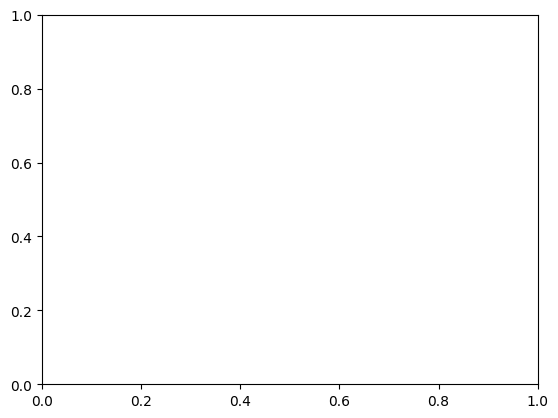

In [16]:
fig, ax = plt.subplots()
ax.plot(hat_p_6_lightcurve_df['time'],hat_p_6_lightcurve_df['aperture_flux']/np.median(hat_p_6_lightcurve_df['aperture_flux']),'.',label='HAT-P-6')
ax.plot(ref_df_1['time'],1+ref_df_1['aperture_flux']/np.median(ref_df_1['aperture_flux']),'.',label='reference 1')
ax.plot(ref_df_2['time'],2+ref_df_2['aperture_flux']/np.median(ref_df_2['aperture_flux']),'.',label='reference 2')
ax.plot(ref_df_3['time'],3+ref_df_3['aperture_flux']/np.median(ref_df_3['aperture_flux']),'.',label='reference 3')
ax.plot(ref_df_4['time'],4+ref_df_4['aperture_flux']/np.median(ref_df_4['aperture_flux']),'.',label='reference 4')
ax.plot(ref_df_5['time'],5+ref_df_5['aperture_flux']/np.median(ref_df_5['aperture_flux']),'.',label='reference 5')
ax.plot(ref_df_6['time'],6+ref_df_6['aperture_flux']/np.median(ref_df_6['aperture_flux']),'.',label='reference 6')
ax.plot(ref_df_7['time'],7+ref_df_7['aperture_flux']/np.median(ref_df_7['aperture_flux']),'.',label='reference 7')
ax.plot(ref_df_8['time'],8+ref_df_8['aperture_flux']/np.median(ref_df_8['aperture_flux']),'.',label='reference 8')
ax.plot(ref_df_9['time'],9+ref_df_9['aperture_flux']/np.median(ref_df_9['aperture_flux']),'.',label='reference 9')
ax.plot(ref_df_10['time'],10+ref_df_10['aperture_flux']/np.median(ref_df_10['aperture_flux']),'.',label='reference 10')
#ax.set_ylim(.9,1.2)
ax.legend()

So, references 5 (a star a bit left of the big one) and 7 (the big one) didn't work, but 8/10 did work. As to not have to run all these each time, perhaps we should pickle these dataframes

<ErrorbarContainer object of 3 artists>

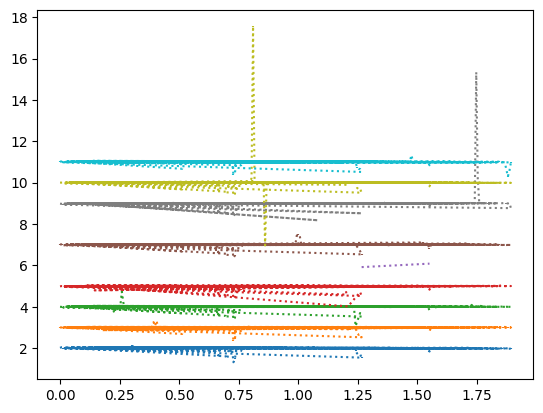

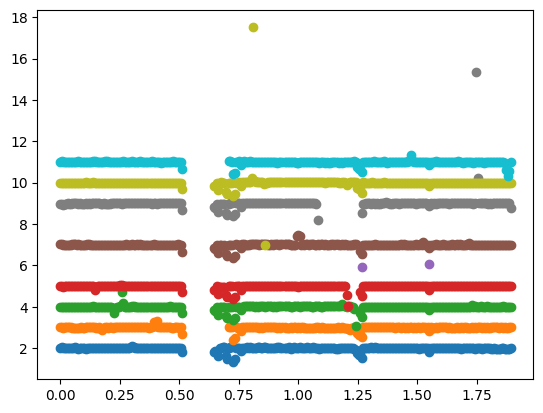

In [56]:
fig, ax = plt.subplots()
ax.errorbar(ref_df_1['time'], 1+ref_df_1['aperture_flux']/np.median(ref_df_1['aperture_flux']),ls='dotted', yerr=ref_df_1['aperture_flux_error']/np.median(ref_df_1['aperture_flux']))
ax.errorbar(ref_df_2['time'], 2+ref_df_2['aperture_flux']/np.median(ref_df_2['aperture_flux']),ls='dotted', yerr=ref_df_2['aperture_flux_error']/np.median(ref_df_2['aperture_flux']))
ax.errorbar(ref_df_3['time'], 3+ref_df_3['aperture_flux']/np.median(ref_df_3['aperture_flux']),ls='dotted', yerr=ref_df_3['aperture_flux_error']/np.median(ref_df_3['aperture_flux']))
ax.errorbar(ref_df_4['time'], 4+ref_df_4['aperture_flux']/np.median(ref_df_4['aperture_flux']),ls='dotted', yerr=ref_df_4['aperture_flux_error']/np.median(ref_df_4['aperture_flux']))
ax.errorbar(ref_df_5['time'], 5+ref_df_5['aperture_flux']/np.median(ref_df_5['aperture_flux']),ls='dotted', yerr=ref_df_5['aperture_flux_error']/np.median(ref_df_5['aperture_flux']))
ax.errorbar(ref_df_6['time'], 6+ref_df_6['aperture_flux']/np.median(ref_df_6['aperture_flux']),ls='dotted', yerr=ref_df_6['aperture_flux_error']/np.median(ref_df_6['aperture_flux']))
ax.errorbar(ref_df_7['time'], 7+ref_df_7['aperture_flux']/np.median(ref_df_7['aperture_flux']),ls='dotted', yerr=ref_df_7['aperture_flux_error']/np.median(ref_df_7['aperture_flux']))
ax.errorbar(ref_df_8['time'], 8+ref_df_8['aperture_flux']/np.median(ref_df_8['aperture_flux']),ls='dotted', yerr=ref_df_8['aperture_flux_error']/np.median(ref_df_8['aperture_flux']))
ax.errorbar(ref_df_9['time'], 9+ref_df_9['aperture_flux']/np.median(ref_df_9['aperture_flux']),ls='dotted', yerr=ref_df_9['aperture_flux_error']/np.median(ref_df_9['aperture_flux']))
ax.errorbar(ref_df_10['time'], 10+ref_df_10['aperture_flux']/np.median(ref_df_10['aperture_flux']),ls='dotted', yerr=ref_df_10['aperture_flux_error']/np.median(ref_df_10['aperture_flux']))

fig, ax = plt.subplots()

# Plot each reference star with better differentiation in line style and color
ax.errorbar(ref_df_1['time'], 1 + ref_df_1['aperture_flux']/np.median(ref_df_1['aperture_flux']), 
            fmt='o', yerr=ref_df_1['aperture_flux_error']/np.median(ref_df_1['aperture_flux']), label="Ref Star 1")
ax.errorbar(ref_df_2['time'], 2 + ref_df_2['aperture_flux']/np.median(ref_df_2['aperture_flux']),
            fmt='o', yerr=ref_df_2['aperture_flux_error']/np.median(ref_df_2['aperture_flux']), label="Ref Star 2")
ax.errorbar(ref_df_3['time'], 3 + ref_df_3['aperture_flux']/np.median(ref_df_3['aperture_flux']),
            fmt='o', yerr=ref_df_3['aperture_flux_error']/np.median(ref_df_3['aperture_flux']), label="Ref Star 3")
ax.errorbar(ref_df_4['time'], 4 + ref_df_4['aperture_flux']/np.median(ref_df_4['aperture_flux']),
            fmt='o', yerr=ref_df_4['aperture_flux_error']/np.median(ref_df_4['aperture_flux']), label="Ref Star 4")
ax.errorbar(ref_df_5['time'], 5 + ref_df_5['aperture_flux']/np.median(ref_df_5['aperture_flux']),
            fmt='o', yerr=ref_df_5['aperture_flux_error']/np.median(ref_df_5['aperture_flux']), label="Ref Star 5")
ax.errorbar(ref_df_6['time'], 6 + ref_df_6['aperture_flux']/np.median(ref_df_6['aperture_flux']),
            fmt='o', yerr=ref_df_6['aperture_flux_error']/np.median(ref_df_6['aperture_flux']), label="Ref Star 6")
ax.errorbar(ref_df_7['time'], 7 + ref_df_7['aperture_flux']/np.median(ref_df_7['aperture_flux']),
            fmt='o', yerr=ref_df_7['aperture_flux_error']/np.median(ref_df_7['aperture_flux']), label="Ref Star 7")
ax.errorbar(ref_df_8['time'], 8 + ref_df_8['aperture_flux']/np.median(ref_df_8['aperture_flux']),
            fmt='o', yerr=ref_df_8['aperture_flux_error']/np.median(ref_df_8['aperture_flux']), label="Ref Star 8")
ax.errorbar(ref_df_9['time'], 9 + ref_df_9['aperture_flux']/np.median(ref_df_9['aperture_flux']),
            fmt='o', yerr=ref_df_9['aperture_flux_error']/np.median(ref_df_9['aperture_flux']), label="Ref Star 9")
ax.errorbar(ref_df_10['time'], 10 + ref_df_10['aperture_flux']/np.median(ref_df_10['aperture_flux']),
            fmt='o', yerr=ref_df_10['aperture_flux_error']/np.median(ref_df_10['aperture_flux']), label="Ref Star 10")


In [52]:
"""fig, ax = plt.subplots()
ax.errorbar([1,4,3,2],[10,15,12,13],yerr=[1,1,1,1],xerr=None,fmt=None)"""

'fig, ax = plt.subplots()\nax.errorbar([1,4,3,2],[10,15,12,13],yerr=[1,1,1,1],xerr=None,fmt=None)'

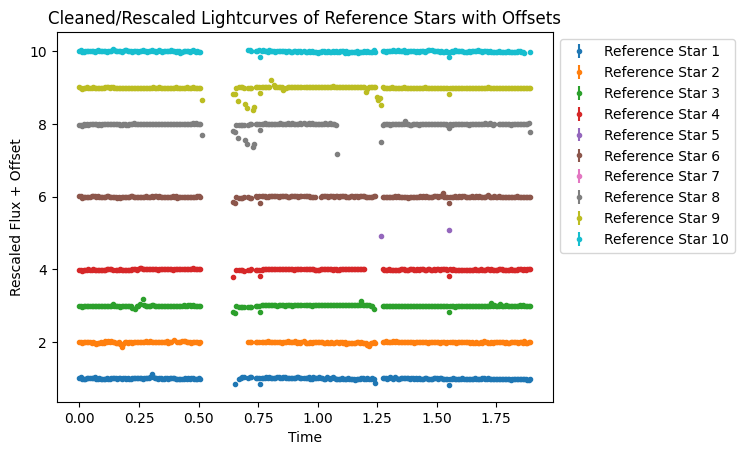

In [77]:
# Function to calculate rescaled flux and rescaled flux error
def calculate_rescaled_flux(df):
    # Calculate the median flux
    avg_flux = np.median(df['aperture_flux'])
    
    # Calculate rescaled flux and rescaled flux error
    df['rescaled_flux'] = df['aperture_flux'] / avg_flux
    df['rescaled_flux_error'] = df['aperture_flux_error'] / avg_flux
    
    return df

# Function to remove outliers from data based on a threshold of standard deviations
def remove_outliers(df, threshold=2):
     #threshold for within how many STDEV are we manipulating outlier data. 
    median_flux = np.median(df['rescaled_flux'])
    std_flux = np.std(df['rescaled_flux'])
    
    # Filter to keep only the values within the threshold
    df_cleaned = df[np.abs(df['rescaled_flux'] - median_flux) < threshold * std_flux]
    return df_cleaned

# Apply rescaling and outlier removal for each reference star
reference_stars = [ref_df_1, ref_df_2, ref_df_3, ref_df_4, ref_df_5, 
                   ref_df_6, ref_df_7, ref_df_8, ref_df_9, ref_df_10]

cleaned_reference_stars = []
for star_df in reference_stars:
    # Calculate rescaled flux and error
    star_df_rescaled = calculate_rescaled_flux(star_df)
    
    # Remove outliers after rescaling
    star_df_cleaned = remove_outliers(star_df_rescaled)
    
    # Add the cleaned dataframe to the list
    cleaned_reference_stars.append(star_df_cleaned)

# Plot the cleaned and rescaled data
fig, ax = plt.subplots()

#offsets for visualization
offset = 1.0  # Initial offset
for i, star_df in enumerate(cleaned_reference_stars):
    ax.errorbar(star_df['time'], star_df['rescaled_flux']+ offset * i, 
                yerr=star_df['rescaled_flux_error'], fmt='.', label=f'Reference Star {i+1}')

#ax.plot(hat_p_6_lightcurve_df['time'],hat_p_6_lightcurve_df['aperture_flux']/np.median(hat_p_6_lightcurve_df['aperture_flux']),'.',label='HAT-P-6')
#labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Rescaled Flux + Offset')
ax.set_title('Cleaned/Rescaled Lightcurves of Reference Stars with Offsets')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()